# Kaggle Dog Bred Classifier

 
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.gpu_options.visible_device_list = "0"

#set_session(tf.Session(config=config))

num_cores = 4


config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})  #GPUs set to zero so we only use CPU
session = tf.Session(config=config)
set_session(session)



Using TensorFlow backend.


In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [4]:
from io import BytesIO
import cv2
from tqdm import tqdm

import re

import time
from datetime import timedelta

import PIL.Image

from scipy.stats import itemfreq
import scipy.io as sio

from sklearn.model_selection import train_test_split


## Import data - taken from a Kaggle kernel example

### Set up the import

In [5]:
stanford_list_path = "./lists/file_list.mat"
file_list = sio.loadmat(stanford_list_path)

In [6]:
file_list

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:29:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
        [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9844.jpg'], dtype='<U48')],
        [array(['n02116738-African_hunting_dog/n02116738_9924.jpg'], dtype='<U48')]],
       dtype=object),
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
        [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
        ...,
        [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],


In [7]:
f = file_list['file_list']
#print(f)
f = np.squeeze(f)
#print(f)
#files = np.squeeze(files)
dog_pattern = re.compile(r'(?<=-)[^\/]+')
file_names = list()
dog_names = list()
for name in f:
    #print(name)
    file_names.append(name[0])
    match = dog_pattern.search(name[0])
    dog_names.append(match.group(0))
    #print(match)
    #dog_names.append(dog_pattern.search(name[0]).group(1))
#file_names = np.array(file_names)
print(file_names[300],dog_names[300])


n02085782-Japanese_spaniel/n02085782_4574.jpg Japanese_spaniel


In [8]:
l = file_list['labels']
labels = list()
for name in l:
    labels.append(name[0])

dog_name_list = dict(list(zip(labels,dog_names)))
print(dog_name_list)


{1: 'Chihuahua', 2: 'Japanese_spaniel', 3: 'Maltese_dog', 4: 'Pekinese', 5: 'Shih-Tzu', 6: 'Blenheim_spaniel', 7: 'papillon', 8: 'toy_terrier', 9: 'Rhodesian_ridgeback', 10: 'Afghan_hound', 11: 'basset', 12: 'beagle', 13: 'bloodhound', 14: 'bluetick', 15: 'black-and-tan_coonhound', 16: 'Walker_hound', 17: 'English_foxhound', 18: 'redbone', 19: 'borzoi', 20: 'Irish_wolfhound', 21: 'Italian_greyhound', 22: 'whippet', 23: 'Ibizan_hound', 24: 'Norwegian_elkhound', 25: 'otterhound', 26: 'Saluki', 27: 'Scottish_deerhound', 28: 'Weimaraner', 29: 'Staffordshire_bullterrier', 30: 'American_Staffordshire_terrier', 31: 'Bedlington_terrier', 32: 'Border_terrier', 33: 'Kerry_blue_terrier', 34: 'Irish_terrier', 35: 'Norfolk_terrier', 36: 'Norwich_terrier', 37: 'Yorkshire_terrier', 38: 'wire-haired_fox_terrier', 39: 'Lakeland_terrier', 40: 'Sealyham_terrier', 41: 'Airedale', 42: 'cairn', 43: 'Australian_terrier', 44: 'Dandie_Dinmont', 45: 'Boston_bull', 46: 'miniature_schnauzer', 47: 'giant_schnauzer

In [9]:

#labels = pd.DataFrame(list(zip(file_names,dog_names,labels)), columns = ['file','breed', 'label'])
labels_raw = pd.DataFrame(list(zip(file_names,dog_names)), columns = ['file','breed'])
labels_raw.sample(5)
#labels[200]
#file = './' + labels[200][0]
#print(file)

,file,breed
15957,n02108551-Tibetan_mastiff/n02108551_3840.jpg,Tibetan_mastiff
6694,n02095314-wire-haired_fox_terrier/n02095314_15...,wire-haired_fox_terrier
15737,n02108422-bull_mastiff/n02108422_1889.jpg,bull_mastiff
15487,n02108000-EntleBucher/n02108000_3113.jpg,EntleBucher
6064,n02093991-Irish_terrier/n02093991_3330.jpg,Irish_terrier


## Create one-hot lables and load data

In [10]:
#df_labels = pd.read_csv('./labels.csv')
#df_submission = pd.read_csv('./sample_submission.csv')   ## <<<< This was the only line used in the original

#targets_series = pd.Series(df_labels['breed'])
#one_hot = pd.get_dummies(targets_series, sparse = True)

#one_hot_labels = np.asarray(one_hot)

In [11]:
#labels_raw = pd.read_csv("./labels.csv", header=0, sep=',', quotechar='"')

#labels_raw.sample(5)


In [12]:
targets_series = pd.Series(labels_raw['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

#### Define target image size

In [13]:
image_resize = 150
X = []
y = []
X_TESTING = []
Train = []
Train_labels = []

#### Load X

In [14]:
i = 0 
for f, breed in tqdm(labels_raw.values):
    img = cv2.imread('./Images/{}'.format(f))
 #   label = one_hot_labels[i]
    Train.append(cv2.resize(img, (image_resize, image_resize)))
 #   Train_labels.append(label)
    i += 1

100%|██████████| 20580/20580 [02:45<00:00, 124.72it/s]


In [15]:
type(Train)

list

In [16]:
#Train_df = pd.DataFrame(list(zip(Train_labels, Train)))
#Train_df

In [17]:
#y_raw = np.array(Train_labels, np.uint8)
X_raw = np.array(Train, np.float32) / 255.


In [18]:
print(X_raw.shape)
#print(y_raw.shape)


(20580, 150, 150, 3)


In [211]:
#num_class = y_train_raw.shape[1]
#num_class

## Limit the number of Dog Breeds in the data in order to simplify the initial calcs

In [19]:
Nber_of_breeds = 120

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
#    print ('Item frequency:')
#    print (labels_freq_pd)
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = X_raw[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 120 main breeds : (20580,)
- The shape of train_filtered dataset is : (20580, 150, 150, 3)


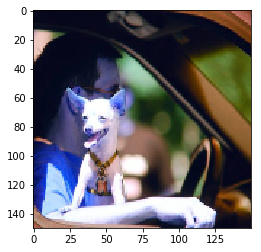

In [20]:
#let's check one image from the train data base
lum_img = train_filtered[100,:,:,:]
plt.imshow(lum_img)
plt.show()

#### Load the lables

### Create 'One-Hot' labels for the data

In [214]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(20580, 1)

In [215]:
#Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [216]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 120
Shape : (20580, 120)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [217]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))
labels[0:9]

Breed 0 : Afghan_hound
Breed 1 : African_hunting_dog
Breed 2 : Airedale
Breed 3 : American_Staffordshire_terrier
Breed 4 : Appenzeller
Breed 5 : Australian_terrier
Breed 6 : Bedlington_terrier
Breed 7 : Bernese_mountain_dog
Breed 8 : Blenheim_spaniel
Breed 9 : Border_collie
Breed 10 : Border_terrier
Breed 11 : Boston_bull
Breed 12 : Bouvier_des_Flandres
Breed 13 : Brabancon_griffon
Breed 14 : Brittany_spaniel
Breed 15 : Cardigan
Breed 16 : Chesapeake_Bay_retriever
Breed 17 : Chihuahua
Breed 18 : Dandie_Dinmont
Breed 19 : Doberman
Breed 20 : English_foxhound
Breed 21 : English_setter
Breed 22 : English_springer
Breed 23 : EntleBucher
Breed 24 : Eskimo_dog
Breed 25 : French_bulldog
Breed 26 : German_shepherd
Breed 27 : German_short-haired_pointer
Breed 28 : Gordon_setter
Breed 29 : Great_Dane
Breed 30 : Great_Pyrenees
Breed 31 : Greater_Swiss_Mountain_dog
Breed 32 : Ibizan_hound
Breed 33 : Irish_setter
Breed 34 : Irish_terrier
Breed 35 : Irish_water_spaniel
Breed 36 : Irish_wolfhound
Bre

array([['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua'],
       ['Chihuahua']], dtype=object)

# Create Test/Train data


In [218]:
X_train, X_test, y_train, y_test = train_test_split(train_filtered, labels_bin, test_size=0.05, random_state=50)
X_train.shape

(19551, 150, 150, 3)

In [219]:
y_train.shape

(19551, 120)

In [220]:
y_test.shape

(1029, 120)

In [221]:
train_filtered = []

In [222]:
Train = []

In [223]:
X_raw = []

# Create the Keras model

In [224]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation='relu',
                 input_shape = (image_resize, image_resize, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(Nber_of_breeds, activation='softmax'))

### Augmentation - taken from an MNIST CNN kernel 

In [225]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True,
                            rotation_range = 90)

In [226]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

#### Compile it

In [227]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

### Run it!

In [228]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                           #steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]), 
                           #initial_epoch = 1,                           
                           callbacks=[annealer]
                          )

Epoch 1/50
 - 3846s - loss: 4.8252 - acc: 0.0151 - val_loss: 12.9291 - val_acc: 0.0120
Epoch 2/50
 - 3903s - loss: 4.6151 - acc: 0.0223 - val_loss: 5.1999 - val_acc: 0.0240
Epoch 3/50
 - 4117s - loss: 4.5010 - acc: 0.0292 - val_loss: 4.6467 - val_acc: 0.0200
Epoch 4/50
 - 4080s - loss: 4.4005 - acc: 0.0393 - val_loss: 4.3184 - val_acc: 0.0480
Epoch 5/50
 - 4098s - loss: 4.3054 - acc: 0.0494 - val_loss: 4.4095 - val_acc: 0.0680
Epoch 6/50
 - 4074s - loss: 4.2288 - acc: 0.0565 - val_loss: 4.2460 - val_acc: 0.0440
Epoch 7/50
 - 4102s - loss: 4.1748 - acc: 0.0599 - val_loss: 4.0353 - val_acc: 0.0600
Epoch 8/50
 - 4096s - loss: 4.1240 - acc: 0.0657 - val_loss: 3.9903 - val_acc: 0.0720
Epoch 9/50
 - 4065s - loss: 4.0699 - acc: 0.0731 - val_loss: 4.5659 - val_acc: 0.0200
Epoch 10/50
 - 4121s - loss: 4.0223 - acc: 0.0783 - val_loss: 4.1668 - val_acc: 0.0680
Epoch 11/50
 - 4122s - loss: 3.9764 - acc: 0.0856 - val_loss: 3.8011 - val_acc: 0.1200
Epoch 12/50
 - 4138s - loss: 3.9178 - acc: 0.0947 -

## Evaluate

We only used a subset of the validation set during training, to save time. Now let's check performance on the whole validation set.


In [229]:

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


Final loss: 3.6625, final accuracy: 0.1380


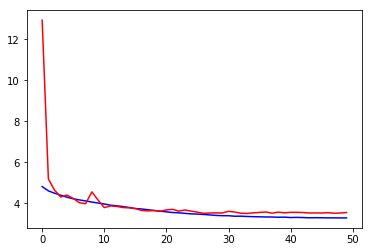

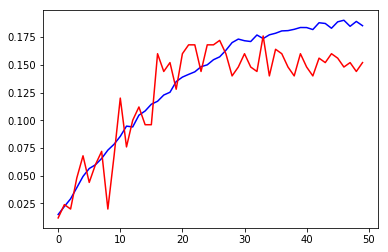

In [230]:

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
__________

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_55 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 150, 150, 32)      25632     
_________________________________________________________________
batch_normalization_56 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 75, 75, 32)        9248      
__________

#### Load X_TESTING

In [ ]:
#for f in tqdm(df_submission['id'].values):
#    img = cv2.imread('../input/test/{}.jpg'.format(f))
#    X_TESTING.append(cv2.resize(img, (im_size, im_size)))
#X_TESTING  = np.array(x_test, np.float32) / 255.

In [236]:
#for f in tqdm(df_submission['id'].values):
X_TESTING = []
img = cv2.imread('./Henry_cropped.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry2.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry3.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry4.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry5.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry7.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Amanda.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Corinne.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Jing.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Karen.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Labrador.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Pam.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
X_TESTING  = np.array(X_TESTING, np.float32) / 255.

In [237]:
prediction = model.predict(X_TESTING, verbose=1)

12/12 [==============================] - 1s 75ms/step


In [242]:
sub = pd.DataFrame(prediction)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
#sub.insert(0, 'id', labels_raw['id'])
actual_names = ['Henry1','Henry2','Henry3','Henry4','Henry5','Henry7', 'Amanda','Corinne','Jing','Karen','Labrador','Pam']
sub.insert(0, 'id', actual_names)

sub

,id,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
0,Henry1,0.007103,0.000389,5.958608e-03,0.001580,6.829274e-08,0.020410,0.001956,1.446464e-08,1.399240e-05,...,2.723139e-05,1.241258e-02,0.181330,0.005273,5.208694e-04,0.064497,4.303661e-05,4.091706e-04,0.000394,0.024055
1,Henry2,0.007009,0.000023,1.247874e-02,0.000780,3.020300e-09,0.043854,0.000417,2.952608e-10,1.512286e-06,...,1.054207e-06,1.607112e-02,0.143546,0.003060,5.792753e-04,0.036124,5.900198e-06,5.573469e-05,0.000086,0.012491
2,Henry3,0.001836,0.000131,1.993630e-04,0.002673,3.161594e-08,0.001709,0.020364,1.471608e-08,1.757217e-06,...,1.645341e-05,2.002906e-03,0.104208,0.007026,1.197547e-03,0.050104,8.067869e-05,4.497944e-06,0.000954,0.010475
3,Henry4,0.036102,0.000007,6.710052e-03,0.000623,1.962434e-10,0.018749,0.002794,4.379850e-11,3.380719e-07,...,1.329403e-06,2.647436e-03,0.067792,0.023454,1.234425e-04,0.074411,6.124716e-07,1.099328e-05,0.000021,0.009064
4,Henry5,0.000566,0.000003,9.778300e-05,0.000309,3.254517e-11,0.007141,0.000143,7.836433e-12,4.211484e-06,...,6.606268e-08,1.214302e-03,0.061679,0.000709,1.301537e-05,0.080268,1.384347e-05,8.664997e-06,0.000053,0.004529
5,Henry7,0.002915,0.000015,4.594372e-03,0.000377,5.357989e-11,0.037022,0.000131,4.596875e-12,1.106272e-07,...,5.638124e-07,5.819658e-03,0.227045,0.001518,2.527122e-04,0.057626,1.274458e-06,1.232074e-05,0.000015,0.005461
6,Amanda,0.000016,0.000641,7.517142e-07,0.000324,3.917612e-03,0.000002,0.000036,1.590452e-02,8.301193e-04,...,1.104926e-05,7.871233e-06,0.000010,0.000094,1.157701e-04,0.000013,2.197687e-02,2.626105e-07,0.000768,0.002436
7,Corinne,0.000028,0.000036,1.151156e-07,0.001461,2.545273e-08,0.000004,0.001513,6.316177e-08,3.277867e-05,...,1.080365e-05,8.813248e-07,0.000825,0.003393,2.520438e-07,0.339255,1.648585e-04,4.636232e-07,0.000815,0.000105
8,Jing,0.000241,0.000298,3.766227e-07,0.005654,2.469828e-04,0.000002,0.004738,1.190057e-03,1.876980e-04,...,1.178600e-03,5.156571e-06,0.000171,0.007436,2.288539e-04,0.002691,1.525879e-02,1.343359e-06,0.005046,0.013616
9,Karen,0.007874,0.008492,8.350184e-04,0.007271,1.119173e-02,0.004178,0.000621,1.719833e-02,4.841831e-06,...,3.973912e-02,4.432003e-04,0.000110,0.007785,5.087479e-03,0.002310,2.659467e-02,4.930005e-05,0.000644,0.000857


In [243]:
sub = sub.set_index('id')
sub


,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,Blenheim_spaniel,Border_collie,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
id,,,,,,,,,,,,,,,,,,,,,
Henry1,0.007103,0.000389,5.958608e-03,0.001580,6.829274e-08,0.020410,0.001956,1.446464e-08,1.399240e-05,1.723163e-07,...,2.723139e-05,1.241258e-02,0.181330,0.005273,5.208694e-04,0.064497,4.303661e-05,4.091706e-04,0.000394,0.024055
Henry2,0.007009,0.000023,1.247874e-02,0.000780,3.020300e-09,0.043854,0.000417,2.952608e-10,1.512286e-06,1.084863e-08,...,1.054207e-06,1.607112e-02,0.143546,0.003060,5.792753e-04,0.036124,5.900198e-06,5.573469e-05,0.000086,0.012491
Henry3,0.001836,0.000131,1.993630e-04,0.002673,3.161594e-08,0.001709,0.020364,1.471608e-08,1.757217e-06,1.033958e-06,...,1.645341e-05,2.002906e-03,0.104208,0.007026,1.197547e-03,0.050104,8.067869e-05,4.497944e-06,0.000954,0.010475
Henry4,0.036102,0.000007,6.710052e-03,0.000623,1.962434e-10,0.018749,0.002794,4.379850e-11,3.380719e-07,1.304377e-08,...,1.329403e-06,2.647436e-03,0.067792,0.023454,1.234425e-04,0.074411,6.124716e-07,1.099328e-05,0.000021,0.009064
Henry5,0.000566,0.000003,9.778300e-05,0.000309,3.254517e-11,0.007141,0.000143,7.836433e-12,4.211484e-06,1.252386e-09,...,6.606268e-08,1.214302e-03,0.061679,0.000709,1.301537e-05,0.080268,1.384347e-05,8.664997e-06,0.000053,0.004529
Henry7,0.002915,0.000015,4.594372e-03,0.000377,5.357989e-11,0.037022,0.000131,4.596875e-12,1.106272e-07,4.680736e-10,...,5.638124e-07,5.819658e-03,0.227045,0.001518,2.527122e-04,0.057626,1.274458e-06,1.232074e-05,0.000015,0.005461
Amanda,0.000016,0.000641,7.517142e-07,0.000324,3.917612e-03,0.000002,0.000036,1.590452e-02,8.301193e-04,5.884404e-03,...,1.104926e-05,7.871233e-06,0.000010,0.000094,1.157701e-04,0.000013,2.197687e-02,2.626105e-07,0.000768,0.002436
Corinne,0.000028,0.000036,1.151156e-07,0.001461,2.545273e-08,0.000004,0.001513,6.316177e-08,3.277867e-05,8.979132e-07,...,1.080365e-05,8.813248e-07,0.000825,0.003393,2.520438e-07,0.339255,1.648585e-04,4.636232e-07,0.000815,0.000105
Jing,0.000241,0.000298,3.766227e-07,0.005654,2.469828e-04,0.000002,0.004738,1.190057e-03,1.876980e-04,4.474198e-02,...,1.178600e-03,5.156571e-06,0.000171,0.007436,2.288539e-04,0.002691,1.525879e-02,1.343359e-06,0.005046,0.013616


In [244]:
nlargest = 10
order = np.argsort(-sub.values, axis=1)[:, :nlargest]
result = pd.DataFrame(sub.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=sub.index)

print(result)

                                 top1                         top2  \
id                                                                   
Henry1    soft-coated_wheaten_terrier             Lakeland_terrier   
Henry2    soft-coated_wheaten_terrier               Dandie_Dinmont   
Henry3                          Lhasa  soft-coated_wheaten_terrier   
Henry4                 Dandie_Dinmont                        cairn   
Henry5                          Lhasa                         chow   
Henry7    soft-coated_wheaten_terrier                        cairn   
Amanda                  Saint_Bernard            Shetland_sheepdog   
Corinne                   Maltese_dog                   toy_poodle   
Jing                 Japanese_spaniel               Siberian_husky   
Karen         black-and-tan_coonhound              Tibetan_mastiff   
Labrador                        Lhasa             Sealyham_terrier   
Pam                 Shetland_sheepdog                     papillon   

                   

In [ ]:



prediction = model.predict(np.array(tk.texts_to_sequences(text)))
print(prediction)